<a href="https://colab.research.google.com/github/semidust/Batik-Classification/blob/main/Batik%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
!pip install split-folders

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

import zipfile, os
import splitfolders

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import math

from itertools import islice

# Load Data

Sumber Dataset: [Semarang Batik Dataset](https://www.kaggle.com/datasets/edywinarno/semarang-batik-dataset/data)

In [ ]:
od.download('https://www.kaggle.com/datasets/edywinarno/semarang-batik-dataset/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: semidust
Your Kaggle Key: ··········


100%|██████████| 12.0G/12.0G [09:47<00:00, 22.0MB/s]


Membagi dataset menjadi 60% data latih, 39.5% data validasi, dan 0.5% data testing.

In [ ]:
base_dir = '/content/semarang-batik-dataset'

splitfolders.ratio(base_dir, output=base_dir, ratio=(0.7,0.295,0.005))

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

Copying files: 3020 files [01:48, 27.79 files/s]


In [ ]:
pd.Series(os.listdir(train_dir))

0          Batik Cap Blekok Warak
1        Batik Cap Kembang Sepatu
2            Batik Cap Asem Arang
3             Batik Cap Tugu Muda
4      Batik Cap Warak Beras Utah
5            Batik Cap Asem Warak
6    Batik Cap Gambang Semarangan
7            Batik Cap Semarangan
8            Batik Cap Asem Sinom
9                Batik Cap Blekok
dtype: object

In [ ]:
pd.Series(os.listdir(validation_dir))

0          Batik Cap Blekok Warak
1        Batik Cap Kembang Sepatu
2            Batik Cap Asem Arang
3             Batik Cap Tugu Muda
4      Batik Cap Warak Beras Utah
5            Batik Cap Asem Warak
6    Batik Cap Gambang Semarangan
7            Batik Cap Semarangan
8            Batik Cap Asem Sinom
9                Batik Cap Blekok
dtype: object

Direktori data latih dan data validasi kini masing-masing memiliki 10 sub-direktori jenis batik berdasarkan motifnya.

# ImageDataGenerator

In [ ]:
img = load_img('/content/semarang-batik-dataset/Batik Cap Asem Arang/asem arang (1).JPG')
img_arr = img_to_array(img)

img_arr.shape

(2449, 2565, 3)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.4,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 2112 images belonging to 10 classes.
Found 885 images belonging to 10 classes.


# Arsitektur Model CNN

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 dropout (Dropout)           (None, 254, 254, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 32)      9248      
                                                        

Compile model untuk menentukan loss function dan optimizer yang digunakan.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy']
)

Penggunaan callback untuk memberhentikan epoch jika nilai akurasi lebih besar dari 97%.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95):
      print("\nAkurasi telah mencapai > 95%!")
      self.model.stop_training= True

callbacks = myCallback()

Melatih model menggunakan method fit().

In [ ]:
start = time.time()

history = model.fit(
      train_generator,
      steps_per_epoch=35,
      epochs=35,
      validation_data=validation_generator,
      validation_steps=20,
      verbose=2,
      callbacks=[callbacks]
)

stop = time.time()
print(f'Time = {(stop-start)/60} minutes')

Epoch 1/35
35/35 - 337s - loss: 1.9687 - accuracy: 0.2679 - val_loss: 1.2942 - val_accuracy: 0.5266 - 337s/epoch - 10s/step
Epoch 2/35
35/35 - 272s - loss: 1.2085 - accuracy: 0.5009 - val_loss: 0.6991 - val_accuracy: 0.6234 - 272s/epoch - 8s/step
Epoch 3/35
35/35 - 267s - loss: 0.7797 - accuracy: 0.6786 - val_loss: 0.4174 - val_accuracy: 0.8891 - 267s/epoch - 8s/step
Epoch 4/35
35/35 - 308s - loss: 0.4690 - accuracy: 0.8205 - val_loss: 0.4370 - val_accuracy: 0.8625 - 308s/epoch - 9s/step
Epoch 5/35
35/35 - 314s - loss: 0.2728 - accuracy: 0.8964 - val_loss: 0.0786 - val_accuracy: 0.9844 - 314s/epoch - 9s/step
Epoch 6/35
35/35 - 308s - loss: 0.2811 - accuracy: 0.9071 - val_loss: 0.2145 - val_accuracy: 0.9094 - 308s/epoch - 9s/step
Epoch 7/35
35/35 - 305s - loss: 0.1949 - accuracy: 0.9366 - val_loss: 0.0435 - val_accuracy: 0.9875 - 305s/epoch - 9s/step
Epoch 8/35

Akurasi telah mencapai > 95%!
35/35 - 264s - loss: 0.1365 - accuracy: 0.9563 - val_loss: 0.0767 - val_accuracy: 0.9703 - 264s/

# Evaluate Model

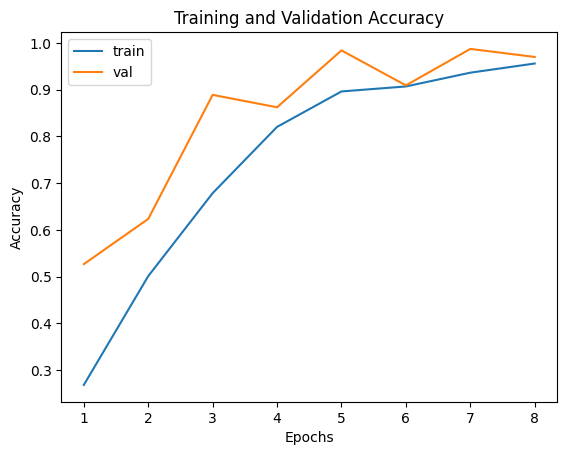

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_accuracy) + 1)

plt.plot(epochs, training_accuracy, label='train')
plt.plot(epochs, validation_accuracy, label='val')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

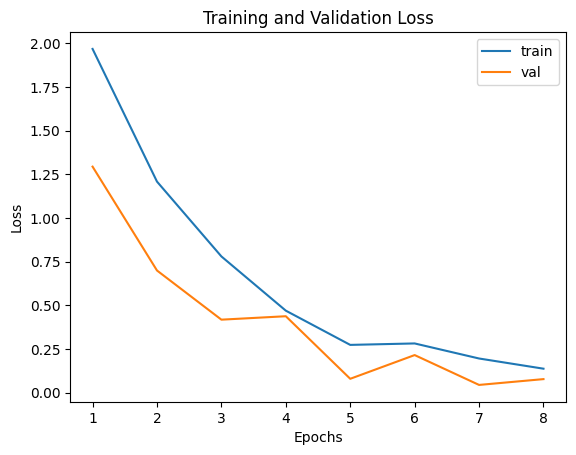

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='train')
plt.plot(epochs, validation_loss, label='val')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
class_indices = train_generator.class_indices
print(pd.Series(class_indices))

Batik Cap Asem Arang            0
Batik Cap Asem Sinom            1
Batik Cap Asem Warak            2
Batik Cap Blekok                3
Batik Cap Blekok Warak          4
Batik Cap Gambang Semarangan    5
Batik Cap Kembang Sepatu        6
Batik Cap Semarangan            7
Batik Cap Tugu Muda             8
Batik Cap Warak Beras Utah      9
dtype: int64


In [ ]:
def get_class_name(label):
    class_names = {
        0: 'Batik Cap Asem Arang',
        1: 'Batik Cap Asem Sinom',
        2: 'Batik Cap Asem Warak',
        3: 'Batik Cap Blekok',
        4: 'Batik Cap Blekok Warak',
        5: 'Batik Cap Gambang Semarangan',
        6: 'Batik Cap Kembang Sepatu',
        7: 'Batik Cap Semarangan',
        8: 'Batik Cap Tugu Muda',
        9: 'Batik Cap Warak Beras Utah'
    }
    return class_names[label]

1/1 [==============================] - 0s 20ms/step


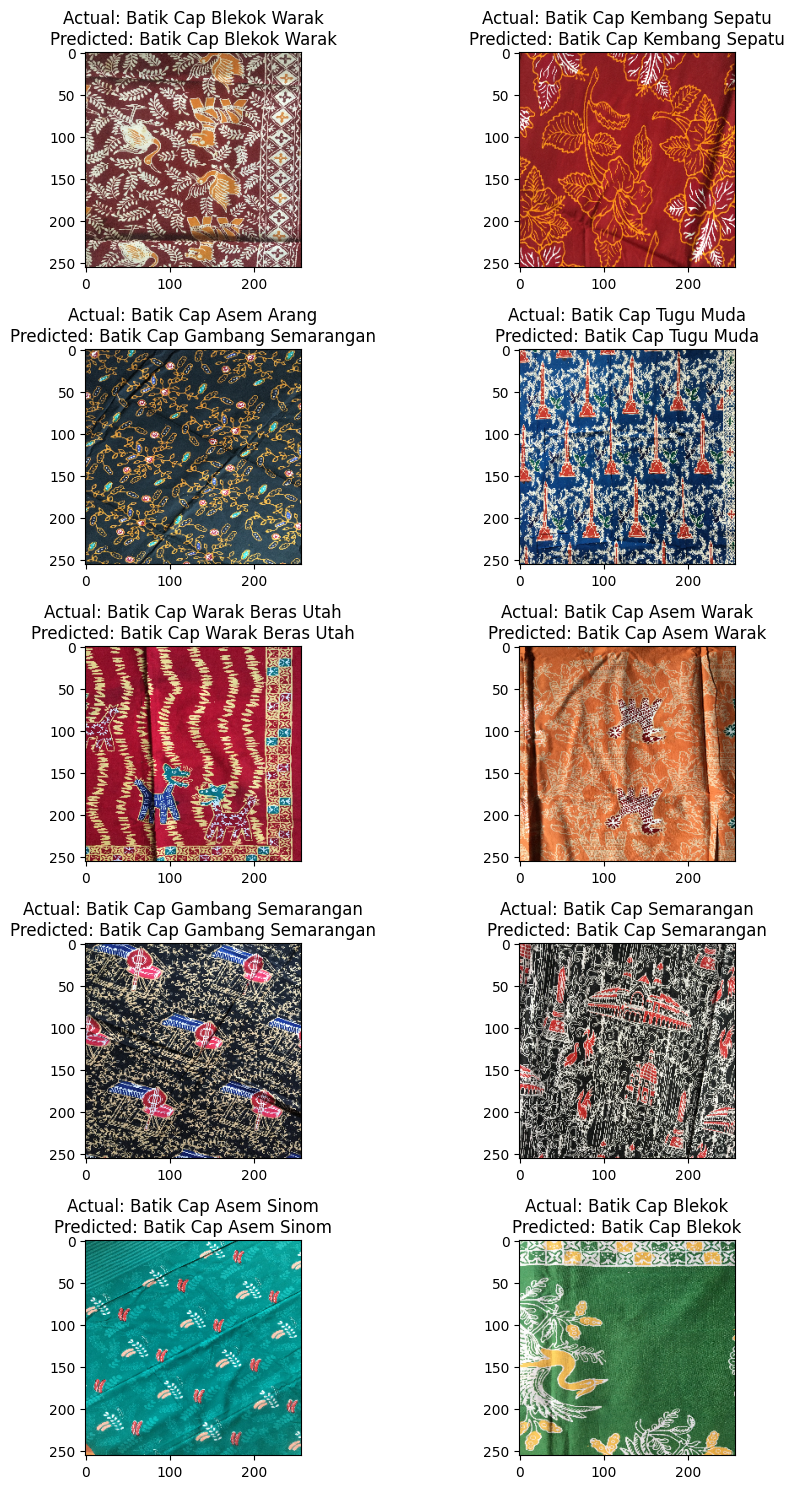

In [ ]:
directory_path = '/content/semarang-batik-dataset/test'

num_cols = 2
num_rows = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))

for i, (root, dirs, files) in enumerate(islice(os.walk(directory_path), 1, None)):
    if i >= num_rows * num_cols:
        break

    # mengatur indeks baris dan kolom berdasarkan nomor iterasi
    row_index = i // num_cols
    col_index = i % num_cols

    # memastikan subdirektori tidak kosong
    if len(files) > 0:
        filename = files[0]
        path = os.path.join(root, filename)

        # periksa apakah termasuk file atau bukan
        if os.path.isfile(path):
            # nama batik actual diambil dari nama path
            actual_batik = os.path.basename(os.path.dirname(path))

            # menampilkan gambar pada subplot
            img = image.load_img(path, target_size=(256, 256))
            axes[row_index, col_index].imshow(img)

            # menggunakan model untuk memprediksi kelas
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            images = np.vstack([x])
            predicted_classes = model.predict(images, batch_size=10)
            predicted_class_index = np.argmax(predicted_classes)
            predicted_class_label = get_class_name(predicted_class_index)

            axes[row_index, col_index].set_title(f"Actual: {actual_batik}\nPredicted: {predicted_class_label}")

# menyembunyikan subplot yang tidak terpakai
for i in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()